In [74]:
## data.py
import pandas as pd
import numpy as np
import torch

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
def sample_interior(
    n_samples: int,
    x_range: tuple = (0, 1),
    y_range: tuple = (0, 1),
    device :  str = 'cpu'
) -> torch.Tensor:
    """ 
    Sample points in the interior of the domain.
    Args:
        n_samples(int) : Number of samples to be drawn.
        x_range(tuple) : Range of x values.
        y_range(tuple) : Range of y values.
        Returns:
            torch.Tensor : Sampled points of shape (n_samples, 2).
    """
    x_samples = np.random.uniform(x_range[0], x_range[1], n_samples)
    y_samples = np.random.uniform(y_range[0], y_range[1], n_samples)
    samples = np.stack((x_samples, y_samples), axis=1)
    return torch.tensor(samples,dtype= torch.float32).to(device=device)

def sample_boundary(
    n_samples : int,
    x_range: tuple = (0, 1),
    y_range: tuple = (0, 1),
    device :  str = 'cpu'
) -> torch.Tensor:
    #! we'll consider only 0-1,0-1
    """ 
    Sample points and normal vectors on the boundary of the domain.
    Args :
        n_samples_per_edge(int) : Number of samples to be drawn per edge.
        x_range(tuple) : Range of x values.
        y_range(tuple) : Range of y values.

    Returns:
        torch.Tensor : Sampled points of shape (n_samples, 2).
        torch.Tensor : Normal vectors of shape (n_samples, 2).
    """
    n_samples_per_edge = n_samples // 4
    t = np.linspace(0,1,n_samples_per_edge)    
    # Four edges 
    left   = np.stack([np.zeros_like(t), t], axis=1)
    right  = np.stack([np.ones_like(t), t], axis=1)
    bottom = np.stack([t, np.zeros_like(t)], axis=1)
    top    = np.stack([t, np.ones_like(t)], axis=1)
    
    # stack all edge 
    pts = np.vstack([left, right, bottom, top])
    
    # normal vectors
    normals = np.vstack([
        np.tile(np.array([-1, 0]), (n_samples_per_edge, 1)),  # left
        np.tile(np.array([1, 0]), (n_samples_per_edge, 1)),   # right
        np.tile(np.array([0, -1]), (n_samples_per_edge, 1)),  # bottom
        np.tile(np.array([0, 1]), (n_samples_per_edge, 1))     # top
    ])
    
    return (
        torch.tensor(pts,dtype = torch.float32).to(device=device),
        torch.tensor(normals,dtype = torch.float32).to(device=device)
    )
def generate_pts(n_interior : int = 1000, n_boundary : int = 500, device :str = 'cpu'):
    interior_pts = sample_interior(n_interior,device = device)
    boundary_pts,normals = sample_boundary(n_boundary,device = device)
    return interior_pts,boundary_pts,normals
    

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [78]:
class U_FCN(nn.Module):
    def __init__(self,in__features : int = 2, out_features : int = 1, hidden_dims : list = [8,16,32,32,16,8]):
        super(U_FCN,self).__init__()
        layers = []
        input_dim = in__features
        for h_dim in hidden_dims:
            # layers.append(nn.BatchNorm1d(input_dim))
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.Tanh())
            # layers.append(nn.Dropout(p=0.2))
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, out_features))
        self.network = nn.Sequential(*layers)
    def forward(self,x):
        return self.network(x)
    
# ---------------biharmonic operator ---------------

def biharmonic_operator(u : torch.Tensor,x : torch.Tensor):
    """
    Compute Δ²u = Laplacian(Laplacian(u)) using autograd.
    x : torch.Tensor (N,2) with required_grad = True
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    u_x = grad_u[:,0:1]
    u_y = grad_u[:,1:2]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True)[0][:,0:1]
    u_yy = torch.autograd.grad(u_y,x,grad_outputs=torch.ones_like(u_y),create_graph=True)[0][:,1:2]
    lap_u = u_xx + u_yy
    
    grad_lap_u = torch.autograd.grad(lap_u,x,grad_outputs=torch.ones_like(lap_u),create_graph=True)[0]
    lap_u_x = grad_lap_u[:,0:1]
    lap_u_y = grad_lap_u[:,1:2]
    lap_u_xx = torch.autograd.grad(lap_u_x,x,grad_outputs=torch.ones_like(lap_u_x),create_graph=True)[0][:,0:1]
    lap_u_yy = torch.autograd.grad(lap_u_y,x,grad_outputs=torch.ones_like(lap_u_y),create_graph=True)[0][:,1:2]
    
    return lap_u_xx + lap_u_yy


### first order normal derivative
$$
\frac{\partial u}{\partial n} \;=\; \nabla u \cdot \mathbf{n}
$$

### second order normal derivative
$$
\frac{\partial^2 u}{\partial n^2} \;=\; \mathbf{n}^\top H_u\,\mathbf{n}
$$

### equivalent chain rule form 
$$
\frac{\partial^2 u}{\partial n^2}
\;=\;
\mathbf{n}\cdot\nabla\!\big(\mathbf{n}\cdot\nabla u\big)
\;=\;
\mathbf{n}\cdot\nabla\!\Big(\frac{\partial u}{\partial n}\Big).
$$


In [79]:

def compute_second_normal_derivative(u: torch.Tensor, x: torch.Tensor, normal: torch.Tensor):
    """
    Compute the second normal derivative ∂²u/∂n² using autograd.
    u : torch.Tensor (N,1) with required_grad = True
    x : torch.Tensor (N,2)
    normal : torch.Tensor (N,2)
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    du_dn = torch.sum(grad_u * normal, dim=1, keepdim=True) #TODO we could use dot product here
    
    grad_du_dn = torch.autograd.grad(du_dn,x,grad_outputs=torch.ones_like(du_dn),create_graph=True)[0]
    d2u_dn2 = torch.sum(grad_du_dn * normal, dim=1, keepdim=True) #similarily
    
    return d2u_dn2
    

In [80]:
def true_solution(pts):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.to(dtype=torch.float32, device=pts.device)
    x1 = pts[:, 0:1]
    x2 = pts[:, 1:2]

    u =  (x1**2) * (x2**2) * ((1 - x1)**2) * ((1 - x2)**2)
    return u
def funcExact(pts):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.to(dtype=torch.float32, device=pts.device)
    x1 = pts[:,0]
    x2 = pts[:,1]
    f = (
        24.0 * x1**4
        - 48.0 * x1**3
        + 288.0 * x1**2 * x2**2
        - 288.0 * x1**2 * x2
        + 72.0 * x1**2
        - 288.0 * x1 * x2**2
        + 288.0 * x1 * x2
        - 48.0 * x1
        + 24.0 * x2**4
        - 48.0 * x2**3
        + 72.0 * x2**2
        - 48.0 * x2
        + 8.0
    ) 
    return f.unsqueeze(-1)

def func(pts):
    """ 
    utility the bihormonic operator on the true solution
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.clone().detach().requires_grad_(True)
    u = true_solution(pts)
    f = biharmonic_operator(u,pts)
    return f.detach() #simply detach from the grad graph


    

In [81]:
pts = torch.tensor([[0.5,0.5],[0.25,0.75]],dtype = torch.float32,device = device)
u = true_solution(pts)
f = func(pts)
f

tensor([[5.0000],
        [1.8125]], device='cuda:0')

In [82]:
f1 = funcExact(pts)
f1

tensor([[5.0000],
        [1.8125]], device='cuda:0')

In [83]:
def g1(pts):
    """ 
    g1(pts) = u same as the neural apporximator
    """
    return true_solution(pts)

def g2(pts,normals):
    """ 
    g2(pts,normals) = d2u/dn2
    """
    u = true_solution(pts)
    return compute_second_normal_derivative(u,pts,normals)


In [84]:
from tqdm import tqdm

In [85]:
def pde_residual(model,pts):
    device = next(model.parameters()).device
    if not pts.requires_grad:
        pts.requires_grad_(True)
    
    u = model(pts)
    lap2_U = biharmonic_operator(u,pts)
    true_f = funcExact(pts)
    return F.mse_loss(lap2_U,true_f)

def boundary_loss(model,pts,normals,lambda1 : int = 1.0, lambda2 : int = 5.0):
    device = next(model.parameters()).device
    if not pts.requires_grad:
        pts.requires_grad_(True)
    
    u = model(pts)
    d2u_dn2 = compute_second_normal_derivative(u,pts,normals)
    g1_vals = g1(pts)
    loss_g1 = F.mse_loss(u,g1_vals)
    g2_vals = g2(pts,normals)
    loss_g2 = F.mse_loss(d2u_dn2,g2_vals)
    return lambda1 * loss_g1 + lambda2 * loss_g2
    
    

In [86]:
def validate(model,n_interior:int = 1000, n_boundary : int = 500):
    eps = 1e-8
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        interior_pts,boundary_pts,_ = generate_pts(n_interior,n_boundary,device = device)
        pts = torch.cat((interior_pts,boundary_pts),dim = 0)
        u_pred = model(pts).detach().cpu().numpy()
        u_true = true_solution(pts).detach().cpu().numpy()
        rel = np.linalg.norm(u_pred - u_true)/(np.linalg.norm(u_true)+ eps) 
    return rel



        
        
    

In [87]:
def train1(
    model,
    optimizer,
    log_var_pde : torch.nn.Parameter,
    log_var_bndry : torch.nn.Parameter,
    epochs = 10000,
    n_interior : int = 5000,
    n_boundary : int = 1000,
    print_every = 50,
    save_dir = 'biharmonic_pinns' 
):
    losses = []
    pde_losses = []
    device = next(model.parameters()).device
    pbar = tqdm(range(1,epochs + 1),desc="epochs")
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        
        interior_pts,boundary_pts,normals = generate_pts(n_interior=n_interior,n_boundary=n_boundary,device=device)
        interior_pts.requires_grad = True
        boundary_pts.requires_grad = True
        loss_pde = pde_residual(model,interior_pts)
        loss_bndry = boundary_loss(model,boundary_pts,normals)
        #! kendall uncertainity-weighting 
        loss = 0.5*(torch.exp(-log_var_pde)*loss_pde + log_var_pde)  + 0.5*(torch.exp(-log_var_bndry)*loss_bndry + log_var_bndry)
        loss.backward()
        optimizer.step() 
        with torch.no_grad():
            log_var_pde.clamp_(0.0, 5.0)
            log_var_bndry.clamp_(0.0, 5.0)
        losses.append(loss.item())
        pde_losses.append(loss_pde.item())
        pbar.set_description(f"Epoch {epoch}: Loss {loss.item():.6f}")
        pbar.set_postfix({'weight_pde': torch.exp(-log_var_pde).item(), 'weight_bndry': torch.exp(-log_var_bndry).item()})
        if epoch % (epochs // 10) == 0:
            # print({'Total Loss': loss.item(),'actual Pde Loss': loss_pde.item(), 'actual Boundary Loss': loss_bndry.item(), 'Val Rel Error': val_rel_error}) 
            save_path = f"{save_dir}/biharmonic_pinn_epoch{epoch}.pt"
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'log_var_pde': log_var_pde.detach().cpu(),
                'log_var_bndry': log_var_bndry.detach().cpu(),
            }, save_path)
            print(f"Saved to {save_path}")
        if epoch % print_every == 0:
            val_rel_error = validate(model,n_interior=1000,n_boundary=500)
            print({'Total Loss': f"{loss.item():.6f}",'actual Pde Loss': f"{loss_pde.item():.6f}", 'actual Boundary Loss': f"{loss_bndry.item():.6f}", 'Val Rel Error': val_rel_error}) 
    return losses, pde_losses
        
        
    

In [88]:
def train(
    model,
    optimizer,
    epochs = 10000,
    n_interior : int = 5000,
    n_boundary : int = 1000,
    print_every = 50):
    
    device = next(model.parameters()).device
    losses = []
    pde_losses = []
    pbar = tqdm(range(1,epochs + 1),desc="epochs")
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        interior_pts,boundary_pts,normals = generate_pts(n_interior=n_interior,n_boundary=n_boundary,device=device)
        interior_pts.requires_grad = True
        boundary_pts.requires_grad = True
        loss_pde = pde_residual(model,interior_pts)
        loss_bndry = boundary_loss(model,boundary_pts,normals)
        loss = 5*loss_pde + loss_bndry
        loss.backward()
        optimizer.step() 

        losses.append(loss.item())
        pde_losses.append(loss_pde.item())
        pbar.set_description(f"Epoch {epoch}: Loss {loss.item():.6f}")
        if epoch % print_every == 0:
            val_rel_error = validate(model,n_interior=1000,n_boundary=500)
            pbar.set_postfix({'Total Loss': loss.item(),'Pde Loss': loss_pde.item(), 'Boundary Loss': loss_bndry.item(), 'Val Rel Error': val_rel_error})   
    
    return losses, pde_losses
        
        
    

In [89]:
import os 
os.makedirs('Q2biharmonic_pinns',exist_ok=True)

In [90]:
model = U_FCN(in__features=2,out_features=1,hidden_dims=[16,32,64,128,128,64,32,16]).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
log_var_pde = torch.nn.Parameter(torch.tensor(0.0,device= device))
log_var_bndry = torch.nn.Parameter(torch.tensor(0.0,device= device))
optimizer.add_param_group({'params': [log_var_pde, log_var_bndry],'lr' : 1e-5})


In [91]:
checkpoint = torch.load(r'Q2biharmonic_pinns/biharmonic_pinn_epoch2000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [94]:
for i, pg in enumerate(optimizer.param_groups):
    
    print(f"Group {i} LR:", pg['lr'])

Group 0 LR: 1e-09
Group 1 LR: 1.0000000000000001e-11


In [93]:
for i, pg in enumerate(optimizer.param_groups):
    pg['lr'] = pg['lr']*1e-2

In [95]:

losess,pde_losses = train1(
    model,
    optimizer,
    log_var_pde,
    log_var_bndry,
    epochs = 2000,
    n_interior = 2000,
    n_boundary = 1000,
    print_every = 100,
    save_dir = 'Q2biharmonic_pinns'
)

Epoch 100: Loss 0.000887:   5%|▌         | 100/2000 [00:26<08:25,  3.76it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000887', 'actual Pde Loss': '0.000795', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.5543756)}


Epoch 200: Loss 0.000901:  10%|█         | 200/2000 [00:51<07:28,  4.02it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch200.pt
{'Total Loss': '0.000901', 'actual Pde Loss': '0.000822', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.4005938)}


Epoch 300: Loss 0.000843:  15%|█▌        | 300/2000 [01:15<07:33,  3.75it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000843', 'actual Pde Loss': '0.000707', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.472811)}


Epoch 400: Loss 0.000947:  20%|██        | 400/2000 [01:42<06:19,  4.21it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch400.pt
{'Total Loss': '0.000947', 'actual Pde Loss': '0.000914', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.615951)}


Epoch 500: Loss 0.000905:  25%|██▌       | 500/2000 [02:07<06:28,  3.87it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000905', 'actual Pde Loss': '0.000830', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.4932947)}


Epoch 600: Loss 0.000808:  30%|███       | 600/2000 [02:29<04:22,  5.33it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch600.pt
{'Total Loss': '0.000808', 'actual Pde Loss': '0.000636', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.549181)}


Epoch 700: Loss 0.000848:  35%|███▌      | 700/2000 [02:47<05:11,  4.17it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000848', 'actual Pde Loss': '0.000717', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.5019374)}


Epoch 801: Loss 0.000849:  40%|████      | 801/2000 [03:05<03:06,  6.42it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch800.pt
{'Total Loss': '0.000938', 'actual Pde Loss': '0.000896', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.40901)}


Epoch 901: Loss 0.000825:  45%|████▌     | 900/2000 [03:24<03:21,  5.45it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000851', 'actual Pde Loss': '0.000723', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.3133044)}


Epoch 1000: Loss 0.000783:  50%|█████     | 1000/2000 [03:39<02:37,  6.37it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch1000.pt
{'Total Loss': '0.000783', 'actual Pde Loss': '0.000586', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.3234296)}


Epoch 1101: Loss 0.000842:  55%|█████▌    | 1101/2000 [03:56<02:17,  6.54it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000854', 'actual Pde Loss': '0.000729', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.3499227)}


Epoch 1201: Loss 0.000875:  60%|██████    | 1200/2000 [04:14<02:11,  6.08it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch1200.pt
{'Total Loss': '0.000816', 'actual Pde Loss': '0.000653', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.400794)}


Epoch 1301: Loss 0.000883:  65%|██████▌   | 1301/2000 [04:30<01:44,  6.67it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000910', 'actual Pde Loss': '0.000841', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.287142)}


Epoch 1400: Loss 0.000959:  70%|███████   | 1400/2000 [04:48<01:54,  5.25it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch1400.pt
{'Total Loss': '0.000959', 'actual Pde Loss': '0.000939', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.5536647)}


Epoch 1501: Loss 0.000904:  75%|███████▌  | 1501/2000 [05:07<01:36,  5.14it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000901', 'actual Pde Loss': '0.000822', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.6011567)}


Epoch 1601: Loss 0.000926:  80%|████████  | 1601/2000 [05:25<01:00,  6.63it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch1600.pt
{'Total Loss': '0.000826', 'actual Pde Loss': '0.000672', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.4128895)}


Epoch 1700: Loss 0.000989:  85%|████████▌ | 1700/2000 [05:41<00:48,  6.22it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000989', 'actual Pde Loss': '0.000998', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.4375625)}


Epoch 1801: Loss 0.000945:  90%|█████████ | 1801/2000 [05:57<00:29,  6.77it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch1800.pt
{'Total Loss': '0.000927', 'actual Pde Loss': '0.000874', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.438504)}


Epoch 1901: Loss 0.000911:  95%|█████████▌| 1901/2000 [06:13<00:16,  6.08it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001030', 'actual Pde Loss': '0.001080', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.4892135)}


Epoch 2000: Loss 0.000842: 100%|██████████| 2000/2000 [06:29<00:00,  5.13it/s, weight_pde=1, weight_bndry=1]

Saved to Q2biharmonic_pinns/biharmonic_pinn_epoch2000.pt
{'Total Loss': '0.000842', 'actual Pde Loss': '0.000705', 'actual Boundary Loss': '0.000979', 'Val Rel Error': np.float32(5.4222665)}


### chech for the corrctness of the above methods 

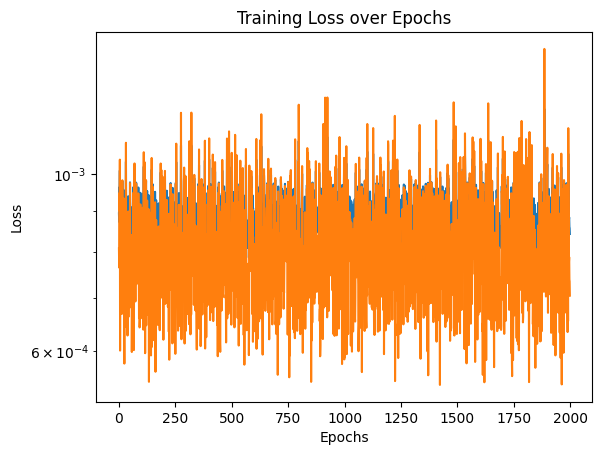

In [96]:
#plot the loss 
import matplotlib.pyplot as plt
plt.plot(losess
         )
plt.plot(pde_losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

### now training is done , next is to visualize the results


In [99]:
#VISUALIZATION
def visualize_solution(model,grid_size : int = 50):
    model.eval()
    device = next(model.parameters()).device
    x = np.linspace(0,1,grid_size)
    y = np.linspace(0,1,grid_size)
    X,Y = np.meshgrid(x,y)
    pts = np.stack([X.flatten(),Y.flatten()],axis=1)
    pts_tensor = torch.tensor(pts,dtype=torch.float32).to(device=device)
    with torch.no_grad():
        u_pred = model(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
        u_true = true_solution(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
    
    fig = plt.figure(figsize=(18,6))
    
    ax1 = fig.add_subplot(1,3,1,projection='3d')
    ax1.plot_surface(X,Y,u_true,cmap='viridis')
    ax1.set_title('True Solution')
    
    ax2 = fig.add_subplot(1,3,2,projection='3d')
    ax2.plot_surface(X,Y,u_pred,cmap='viridis')
    ax2.set_title('Predicted Solution')
    
    ax3 = fig.add_subplot(1,3,3,projection='3d')
    ax3.plot_surface(X,Y,np.abs(u_true - u_pred),cmap='viridis')
    ax3.set_title('Absolute Error')
    
    plt.show()

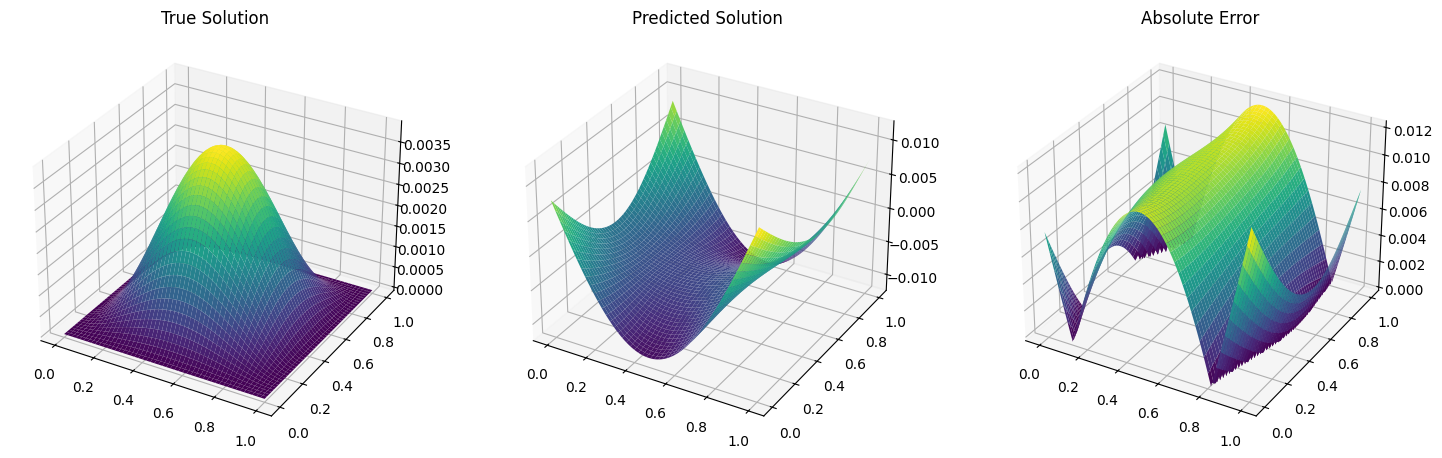

In [100]:
visualize_solution(model,grid_size=1000)

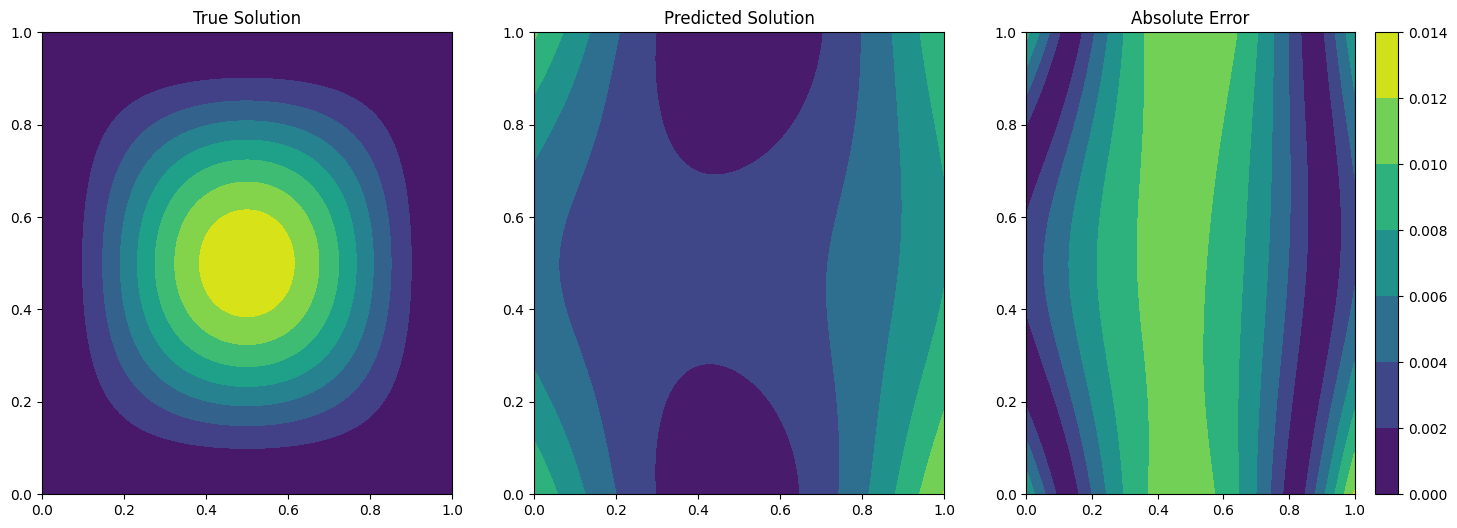

In [102]:
#2d projection visualization
def visualize_solution_2d(model,grid_size : int = 50):
    model.eval()
    device = next(model.parameters()).device
    x = np.linspace(0,1,grid_size)
    y = np.linspace(0,1,grid_size)
    X,Y = np.meshgrid(x,y)
    pts = np.stack([X.flatten(),Y.flatten()],axis=1)
    pts_tensor = torch.tensor(pts,dtype=torch.float32).to(device=device)
    with torch.no_grad():
        u_pred = model(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
        u_true = true_solution(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
    
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1,3,1)
    ax1.contourf(X,Y,u_true,cmap='viridis')
    ax1.set_title('True Solution')
    ax2 = fig.add_subplot(1,3,2)
    ax2.contourf(X,Y,u_pred,cmap='viridis')
    ax2.set_title('Predicted Solution')
    ax3 = fig.add_subplot(1,3,3)
    ax3.contourf(X,Y,np.abs(u_true - u_pred),cmap='viridis')
    ax3.set_title('Absolute Error')
    # add the colorbar
    fig.colorbar(ax3.contourf(X,Y,np.abs(u_true - u_pred),cmap='viridis'), ax=ax3) 
    plt.show()
visualize_solution_2d(model,grid_size=500)